In [1]:
import pybamm
pybamm.settings.heaviside_smoothing = 10
import numpy as np 
import matplotlib.pyplot as plt
import pickle
from joblib import Parallel, delayed
#from jupyterthemes import jtplot
#jtplot.style(theme="monokai", context="notebook", ticks=True, grid=False)
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100
from scipy.optimize import root

from IPython.display import Audio
url = "https://proxy.notificationsounds.com/wake-up-tones/you-have-new-message-484/download/file-a1_ascendent-64kbps.mp3"
notify=Audio(url = url, autoplay = True)
#notify=Audio(filename = "/home/drmrfc/Downloads/echoed-ding-459.mp3", autoplay = True)
########## pickle commands for dumping and retrieving data #######
# filename = 'dogs'
# outfile = open(filename,'wb')
# pickle.dump(dogs_dict,outfile)
# outfile.close()
# infile = open(filename,'rb')
# data = pickle.load(infile)
# infile.close()

########### parallel computations command ####################
# data = Parallel(n_jobs=-1)(delayed(my_function)(i) for i in my_iterable)

# data set when at office 
#filename = '/home/drmrfc/Dropbox/Career/2020 - 2023 Post Doc/LiSTAR/Data/Inhomogeneity/Inhomogeneity/LiS_SingleLayers/reworked_data'
# data set when at home


In [2]:
model = pybamm.lithium_sulfur.ZeroD_Chemistry_1()

param = model.default_parameter_values
param.update(
    {
        "Current function [A]": 1.7,
        
        }
)


sim = pybamm.Simulation(
    model,
    #experiment=experiment,
    parameter_values = param,
    solver=pybamm.CasadiSolver(
        atol=1e-8,
        rtol=1e-5,
        dt_max = .01,
        extra_options_setup={"max_step_size": 0.1}, 
        max_step_decrease_count = 15,
    ),
)
hours = 4.8
time_in_seconds = 7158#3600*3.4/1.7
sim.solve(np.linspace(0, time_in_seconds, int(time_in_seconds)))

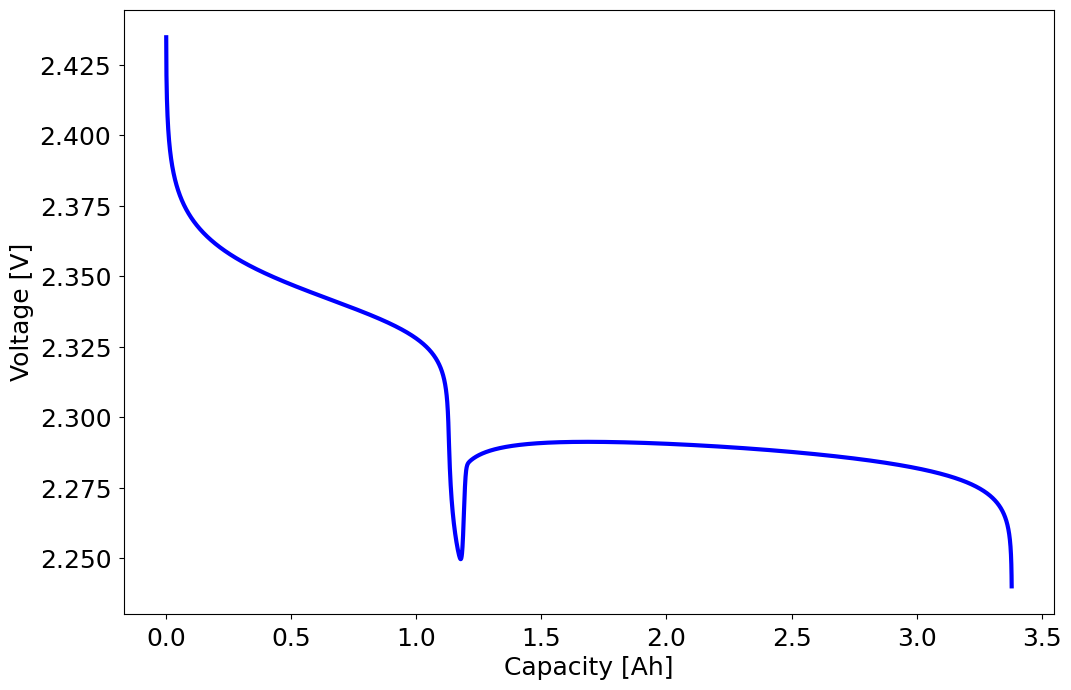

In [19]:
cap = sim.solution.t*1.7/3600
voltage = sim.solution['Terminal voltage [V]'].entries
plt.plot(cap,voltage, color='blue',linewidth = 3)
plt.xlabel('Capacity [Ah]', fontsize = 18)
plt.ylabel('Voltage [V]', fontsize = 18)
plt.tick_params(labelsize=18)

In [14]:
plt.tick_params?

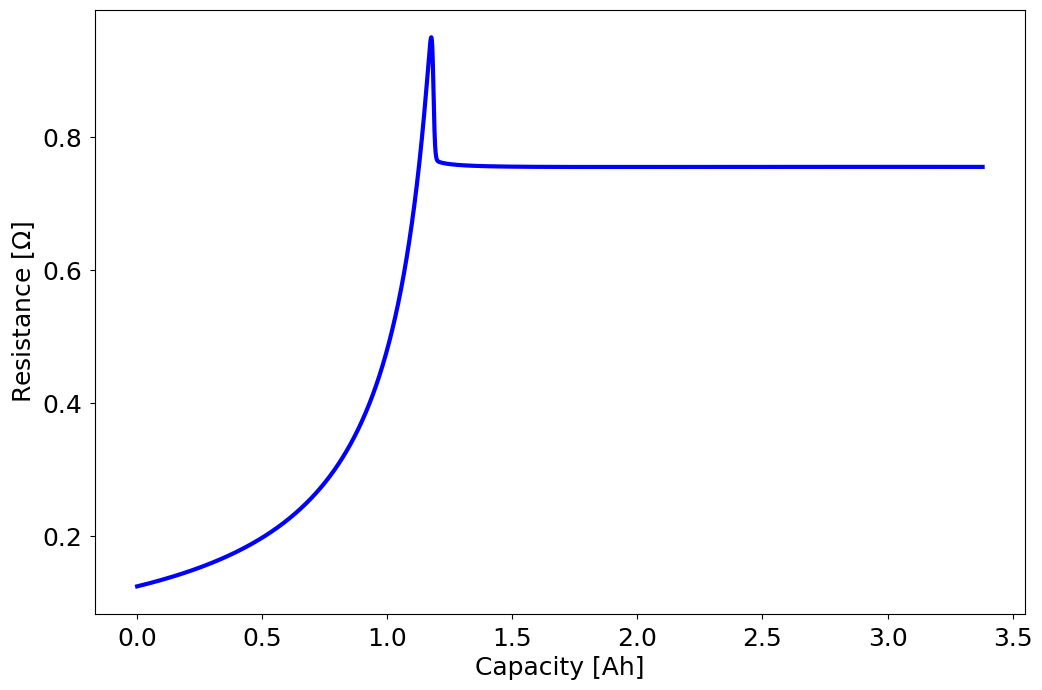

In [22]:
sigma_0 = 2e-2
l =  4e-5
A = 0.15

capacity = 1.7*sim.solution.t/3600
S4 = sim.solution['S4 [g]'].entries
S2 = sim.solution['S2 [g]'].entries
S1 = sim.solution['S [g]'].entries
Li = S1 + 0.5*S2 + 0.25*S4 
b = 8e-2
sigma = sigma_0 - b*(Li)
R = l/(A*sigma)
#plt.plot(capacity,R)
R = .1/(max(Li)*1.15-Li)

plt.plot(capacity, R,color='blue',linewidth=3)
plt.xlabel('Capacity [Ah]',fontsize=18)
plt.ylabel('Resistance [$\Omega$]',fontsize=18)

plt.tick_params(labelsize=18)

In [23]:
S1_initial = sim.solution['S [g]'].entries[-1]
S2_initial = sim.solution['S2 [g]'].entries[-1]
S4_initial = sim.solution['S4 [g]'].entries[-1]
S8_initial = sim.solution['S8 [g]'].entries[-1]
Sp_initial = sim.solution['Precipitated Sulfur [g]'].entries[-1]

In [24]:
model2 = pybamm.lithium_sulfur.ZeroD_Chemistry_1()

param2 = model2.default_parameter_values
param2.update(
    {
        "Current function [A]": -1.7,
        "Initial Condition for S8 ion [g]" : S8_initial,
        "Initial Condition for S4 ion [g]" : S4_initial,
        "Initial Condition for S2 ion [g]" : S2_initial,
        "Initial Condition for S ion [g]" : S1_initial,
        "Initial Condition for Precipitated Sulfur [g]" : Sp_initial,
        #'Precipitation rate [s-1]': 100
        
        }
)


sim2 = pybamm.Simulation(
    model2,
    #experiment=experiment,
    parameter_values = param2,
    solver=pybamm.CasadiSolver(
        atol=1e-8,
        rtol=1e-5,
        dt_max = .01,
        extra_options_setup={"max_step_size": 0.1}, 
        max_step_decrease_count = 15,
    ),
)

time_in_seconds = 3600*3.0/1.7
sim2.solve(np.linspace(0, time_in_seconds, int(time_in_seconds)))

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed


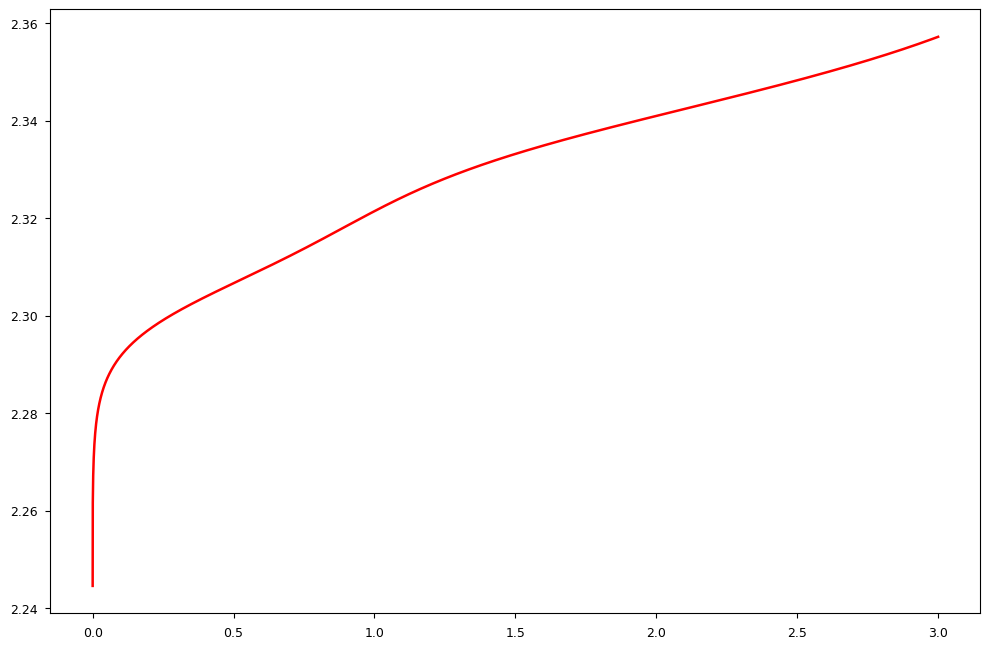

In [25]:
cap2 = sim2.solution.t*1.7/3600
voltage2 = sim2.solution['Terminal voltage [V]'].entries
plt.plot(cap2,voltage2)

In [26]:
def negativity_check(sim):
    S8_end = sim.solution['S8 [g]'].entries[-1]
    S4_end = sim.solution['S4 [g]'].entries[-1]
    S2_end = sim.solution['S2 [g]'].entries[-1]
    S1_end = sim.solution['S [g]'].entries[-1]
    Sp_end = sim.solution['Precipitated Sulfur [g]'].entries[-1]
    if S8_end < 0 or S4_end < 0 or S2_end < 0 or S1_end < 0 or Sp_end < 0:
        print('Negative Species Values!')
        print(S8_end)
        print(S4_end)
        print(S2_end)
        print(S1_end)
        print(Sp_end)
        return True
    else:
        return False
    
def time_check(sim):
    time = int(3600*4/1.7)
    if sim.solution.t[-1] > time:
        return True
    else:
        return False

def voltage_check(sim):
    if sim.solution['Terminal voltage [V]'].entries[-1] < 1.55:
        print('Low Voltage!')
        return True
    else:
        return False

condition = True 
break_condition = True
print('\n\n\n\n\n Trying 100 \n\n\n\n\n')
while condition and break_condition:
    try:
        if negativity_check(sim2) or time_check(sim2) or voltage_check(sim2):
            break_condition = False
        else:
            sim2.step(100)
    except:
        condition = False

condition = True 
print('\n\n\n\n\n Trying 50 \n\n\n\n\n')
while condition and break_condition:
    try:
        if negativity_check(sim2) or time_check(sim2) or voltage_check(sim2):
            break_condition = False
        else:
            sim2.step(50)
    except:
        condition = False

condition = True 
print('\n\n\n\n\n Trying 10 \n\n\n\n\n')
while condition and break_condition:
    try:
        if negativity_check(sim2) or time_check(sim2) or voltage_check(sim2):
            break_condition = False
        else:
            sim2.step(10)
    except:
        condition = False

condition = True 
print('\n\n\n\n\n Trying 1 \n\n\n\n\n')
while condition and break_condition:
    try:
        if negativity_check(sim2) or time_check(sim2) or voltage_check(sim2):
            break_condition = False
        else:
            sim2.step(1)
    except:
        condition = False






 Trying 100 







psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c






 Trying 50 







Newton/Linesearch algorithm failed to converge.
Newton/Linesearch algorithm failed to converge.
Newton/Linesearch algorithm failed to converge.
Newton/Linesearch algorithm failed to converge.
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casad






 Trying 10 










 Trying 1 







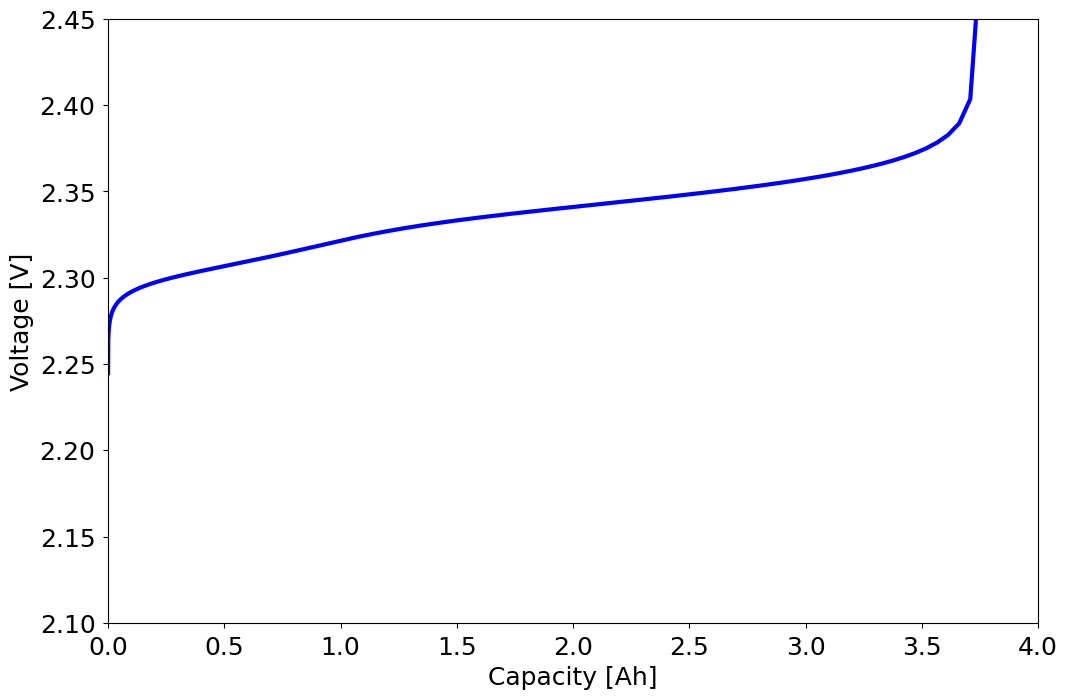

In [28]:
cap2 = sim2.solution.t*1.7/3600
voltage2 = sim2.solution['Terminal voltage [V]'].entries
plt.plot(cap2,voltage2,color="blue",linewidth=3)
plt.ylim([2.1,2.45])
plt.xlim([0,4])
plt.xlabel('Capacity [Ah]',fontsize=18)
plt.ylabel('Voltage [V]',fontsize=18)
plt.tick_params(labelsize=18)

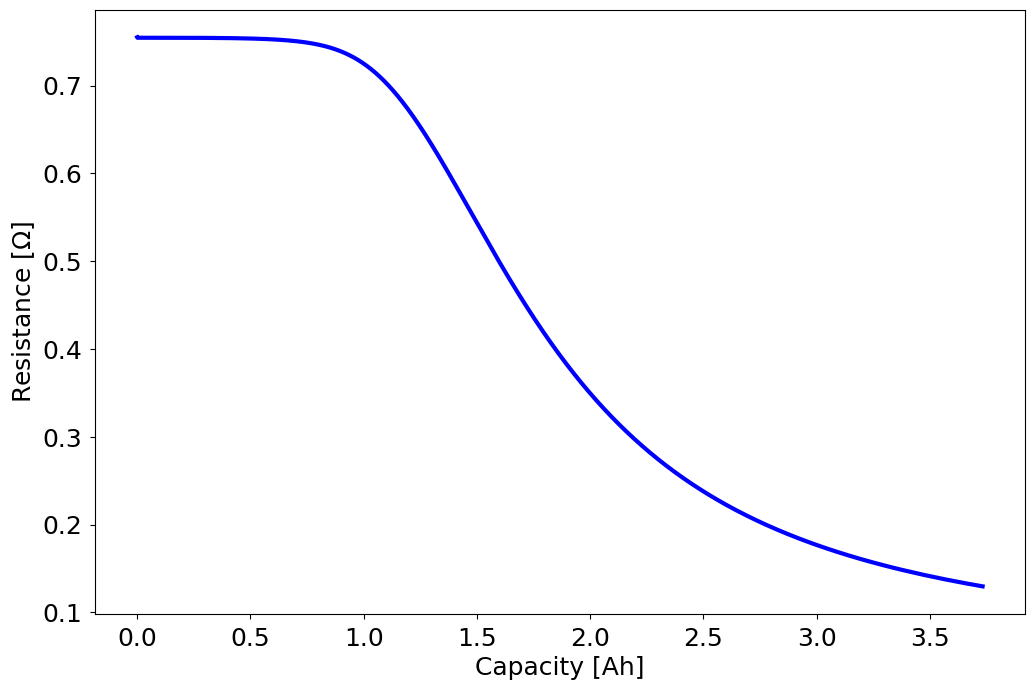

In [29]:
sigma_0 = 2e-2
l =  4e-5
A = 0.15

capacity2 = 1.7*sim2.solution.t/3600
S42 = sim2.solution['S4 [g]'].entries
S22 = sim2.solution['S2 [g]'].entries
S12 = sim2.solution['S [g]'].entries
Li2 = S12 + 0.5*S22 + 0.25*S42 
b = 8e-2
sigma2 = sigma_0 - b*(Li2)
R2 = l/(A*sigma2)
#plt.plot(capacity,R)
R2 = .1/(max(Li)*1.15-Li2)

plt.plot(capacity2, R2,color='blue',linewidth=3)
plt.xlabel('Capacity [Ah]',fontsize=18)
plt.ylabel('Resistance [$\Omega$]',fontsize=18)
plt.tick_params(labelsize=18)